In [45]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

In [46]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image
def draw_lines(img, lines, color=[255, 0, 0], thickness=3):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    if lines is None:
        return img
    
    # filter unwanted lines
    desire_slope_max=2.0
    desire_slope_min=0.5
    
    filtered_lines = []
    for line_list in lines:
        for line in line_list:
            slope = slope_calc(line)
            if slope is not None and desire_slope_min < abs(slope) < desire_slope_max:
                filtered_lines.append(line)

# separate line segments into right and left
# minus slope line mean the right line
    left_lines = []
    right_lines = []
    for line in filtered_lines:
        slope = slope_calc(line)
        if slope > 0.:
            right_lines.append(line)
        else:
            left_lines.append(line)

    # calculate average of line segments
    
    right_line = _average_lines(right_lines, img.shape)
    left_line = _average_lines(left_lines, img.shape)
    for a_line in [left_line, right_line]:
       if a_line is None:
           continue
       x1, y1, x2, y2 = a_line
       cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            
        
def slope_calc(line):
    x1,y1,x2,y2 = line
    slope_line =(y2-y1)/(x2-x1)
    if x2 == x1:  # to avoid devide by zero
        return None
    else:
        return slope_line
    
def length_calc(line):
    " Calculates length of line segment"
    x1,y1,x2,y2 = line
    length_line= np.sqrt((x2-x1)*(x2-x1) + (y2-y1)*(y2-y1))
    
    return length_line
    
    
def intercept_calc(line, slope):
    " Calculates the intercept of line cy = slope * cx + intercept where cx, cy in the center of the line"
    x1,y1,x2,y2 = line
    cx = (x1 + x2) / 2
    cy = (y1 + y2) / 2
    line_intercept= cy - slope * cx
    
    return line_intercept
    
    
# average lines and use weight average method
def _average_lines(lines, img_shape):
    "Calculate the weighted average of lines "
    if lines is None or len(lines) == 0:
        return None
    
    weights = [length_calc(l) for l in lines]        
    slopes = [slope_calc(l) for l in lines]
    weighted_slope_sum = np.inner(slopes, weights)
    sun_weights=sum(weights)
    avg_slope = weighted_slope_sum/sun_weights
    intercepts = [intercept_calc(l, avg_slope) for l in lines]
    weighted_intercepts_sum = np.inner(intercepts, weights)
    avg_intercept = weighted_intercepts_sum/sun_weights
    "extrapolate line to bottom of image"
    # now we have our line y = avg_slope * x + avg_intercept
    # we extrapolate our line to botton of image (y=540)
    # and no more upper than region of interest (y=310)
    width, height, depth = img_shape
    y1 = width * 0.65
    x1 = (y1 - avg_intercept) / avg_slope
    y2 = width
    x2 = (y2 - avg_intercept) / avg_slope
    
    return int(x1), int(y1), int(x2), int(y2)    

#same code from the template        
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img
# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)


def color_of_interest(img, rgb_lower, rgb_upper):
    """ Only allow yellow and white lane lines pass 
    """
    
    #defining a blank mask to start with
    color_select = np.copy(img)
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    mask = cv2.inRange(img, rgb_lower, rgb_upper)
    mask = (mask == 255)
    color_select[~mask] = [0, 0, 0]
    return color_select


In [47]:
import os
image_names = os.listdir("test_images/")

image saved to  output_test_images/solidWhiteCurve.jpg
image saved to  output_test_images/solidWhiteRight.jpg
image saved to  output_test_images/solidYellowCurve.jpg
image saved to  output_test_images/solidYellowCurve2.jpg
image saved to  output_test_images/solidYellowLeft.jpg
image saved to  output_test_images/whiteCarLaneSwitch.jpg


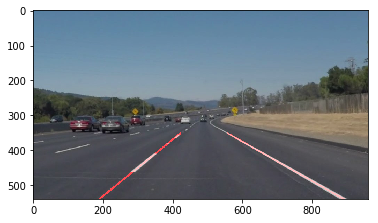

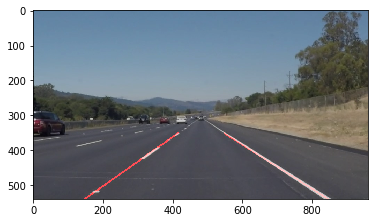

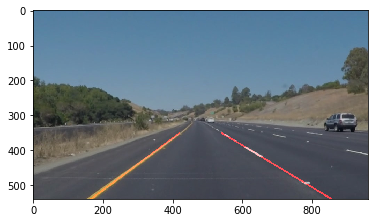

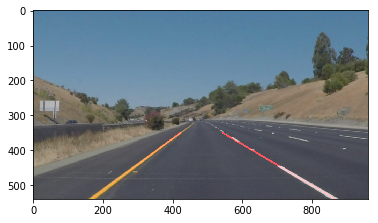

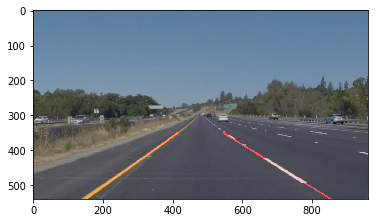

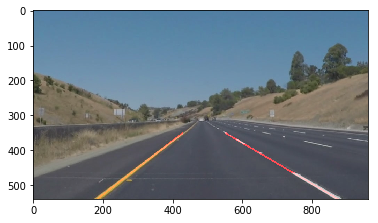

In [48]:
for image_name in image_names:
    image_path = 'test_images/' + image_name
    origin_image = mpimg.imread(image_path)
    
    
    rgb_upper = np.array([255, 255, 255])
    rgb_lower = np.array([170, 170, 80])
    vertices = np.array(
        [[(460,310),(500, 310), (900, 540), (60, 540)]], 
        dtype=np.int32)
    kernal_size = 9
    low_threshold = 50
    high_threshold = 100
    rho = 1
    theta = np.pi / 360.
    threshold = 10  # min num of votes
    min_line_len = 15
    max_line_gap = 1

    # color selection: 
    # let white and yello line pass throught this filter
    image = np.copy(origin_image)
    image = color_of_interest(image, rgb_lower, rgb_upper)
    image = region_of_interest(image, vertices)
    image = grayscale(image)
    image = gaussian_blur(image, kernal_size)
    image = canny(image, low_threshold, high_threshold)
    image = hough_lines(image, rho, theta, threshold, min_line_len, max_line_gap)
    image = weighted_img(image, origin_image)
    out_path = 'output_' + image_path
    plt.imsave(out_path, image)
    print('image saved to ', out_path)
    plt.figure()
    plt.imshow(image)
    
# results are saved to out_test_images directory

In [49]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [50]:
def process_image(origin_image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    image = np.copy(origin_image)
    image = color_of_interest(image, rgb_lower, rgb_upper)
    h, w, _ = image.shape
    vertices = np.array(
        [[(0.48 * w, 0.58 * h),
          (0.52 * w, 0.58 * h), 
          (0.94 * w, h), 
          (0.06 * w, h)]], 
        dtype=np.int32)
    image = region_of_interest(image, vertices)
    image = grayscale(image)
    image = gaussian_blur(image, kernal_size)
    image = canny(image, low_threshold, high_threshold)
    image = hough_lines(image, rho, theta, threshold, min_line_len, max_line_gap)
    image = weighted_img(image, origin_image)    
    return image

In [51]:
yellow_output = 'yellow.mp4'
clip = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4



100%|█████████▉| 681/682 [00:33<00:00, 20.12it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 24.3 s, sys: 4.84 s, total: 29.1 s
Wall time: 34.7 s


In [52]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

In [53]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:10<00:00, 20.49it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 7.68 s, sys: 1.53 s, total: 9.22 s
Wall time: 11.6 s


In [54]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [55]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|██████████| 251/251 [00:21<00:00, 11.47it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 14.6 s, sys: 3.35 s, total: 18 s
Wall time: 24 s


In [56]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))